In [1]:
import glob 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from tensorboardX import SummaryWriter

import umap

import poisevae
from poisevae.datasets import MNIST_SVHN
from poisevae.networks.MNISTSVHNNetworks_1 import EncMNIST, DecMNIST, EncSVHN, DecSVHN

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')
SVHN_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/%s_32x32.mat')
MNIST_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/MNIST_%s_idx.pt')
SVHN_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/SVHN_%s_idx.pt')

joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test')

# joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train', 
#                                 sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'train'), 
#                                 sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'train'))
# joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test',
#                                sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'test'), 
#                                sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'test'))

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(234, 39)

In [6]:
def mask_missing(data):
    # data: (mnist, svhn, label, label)
    rand_num = random.random()
    if rand_num < 0.2: # Send both
        return data
    elif rand_num > 0.6: # Send SVHN only
        return None, *data[1:]
    else: # Send MNIST only
        return data[0], None, *data[2:]

In [7]:
lat1, lat2 = 20, 20
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_svhn = EncSVHN(lat2).to(device)
dec_svhn = DecSVHN(lat2).to(device)

vae = poisevae.POISEVAE_Gibbs('gradient',
                              [enc_mnist, enc_svhn], [dec_mnist, dec_svhn], likelihoods=[Laplace, Laplace],
                              latent_dims=[lat1, (lat2, 1, 1)], enc_config='nu', KL_calc='derivative', 
                              batch_size=batch_size
                             ).to(device)

In [8]:
class SVHN_Classifier(nn.Module):
    def __init__(self):
        super(SVHN_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


class MNIST_Classifier(nn.Module):
    def __init__(self):
        super(MNIST_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
    
clfs = [MNIST_Classifier().to(device), SVHN_Classifier().to(device)]
optims = [optim.Adam(clfs[0].parameters(), lr=1e-3), optim.Adam(clfs[1].parameters(), lr=1e-3)]

100%|█████████████████████████████████████████████████████████████████████████| 50/50 [02:36<00:00,  3.12s/it]


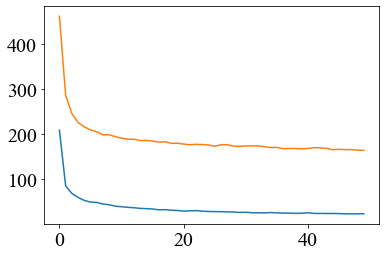

In [9]:
clfs[0].train()
clfs[1].train()
losses = np.zeros((2, 50))
for k in tqdm(range(50)):
    for data in train_loader:
        data[0] = data[0].reshape(-1, 1, 28, 28)
        assert (data[2] == data[3]).all()
        for i, (clf, optimizer) in enumerate(zip(clfs, optims)):
            optimizer.zero_grad()
            pred = clf(data[i].to(device, torch.float32))

            loss = F.cross_entropy(pred, data[i+2].to(device)) 

            losses[i, k] += loss.item()
            loss.backward()
            optimizer.step()
plt.plot(losses[0])
plt.plot(losses[1])

In [10]:
# Eval
clfs[0].eval()
clfs[1].eval()
correct = np.zeros(2)
with torch.no_grad():
    for data in test_loader:
        data[0] = data[0].reshape(-1, 1, 28, 28)
        assert (data[2] == data[3]).all()
        for i, clf in enumerate(clfs):
            _, pred = clf(data[i].to(device, torch.float32)).max(dim=1)
            correct[i] += (pred == data[i+2].to(device)).sum().item()
correct / len(test_loader.dataset)

array([0.98969897, 0.84738474])

In [11]:
path = '../example/'# '../example/runs/MNIST_SVHN/fix_t/2201251135'
# vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(os.path.join(path, 'train*.pt')))[-1])
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_30.pt'))
epoch

30

In [12]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)], 
                          n_gibbs_iter=30)
        break

nu1 max: 256.68695068359375 nu1 mean: 7.671943187713623
nu1p max: 272.0028076171875 nu1p mean: 18.919492721557617
nu2 min: 9.47579993258122e-15 nu2 mean: 49.577606201171875
nu2p min: 0.08733890950679779 nu2p mean: 27.890552520751953
zpost mean: 0.28974905610084534 zppost mean: 0.36225801706314087
zprior mean: 0.29123950004577637 zpprior mean: 0.3494212031364441
zprior min: 6.9551169872283936e-06 zpprior min: 3.933906555175781e-06
zpost min: 4.4852495193481445e-06 zppost min: 2.0228326320648193e-06
zprior max: 2.711440086364746 zpprior max: 3.6748898029327393
zpost max: 2.9397976398468018 zppost max: 3.7424380779266357
total loss: 1885.0966796875 kl term: 0.0
rec1 loss: 406.45026041666665 rec2 loss: 1478.646484375



In [13]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 32, 32]))

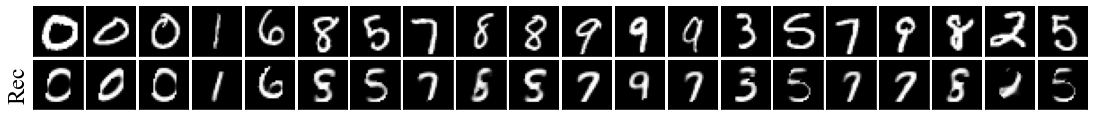

In [14]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

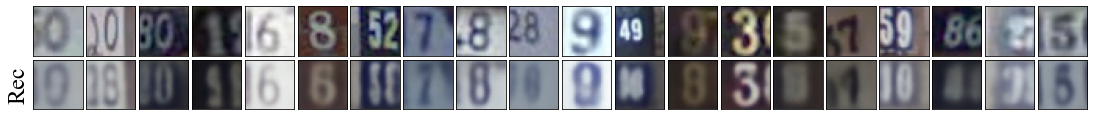

In [15]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

### Cross Generation

#### MNIST -> SVHN

In [29]:
correct = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            results = vae([data[0].to(device, dtype=torch.float32), None], n_gibbs_iter=100)
        _, pred = clfs[1](results['x_rec'][1].cuda()).max(dim=1)
        correct.append((pred == data[2].to(device)).sum().item() / batch_size)
correct = np.array(correct)
correct.mean(), correct.std()

(0.11909054487179487, 0.021719769500688782)

In [38]:
correct

array([0.10546875, 0.1484375 , 0.1171875 , 0.140625  , 0.1015625 ,
       0.13671875, 0.140625  , 0.1015625 , 0.1171875 , 0.109375  ,
       0.1328125 , 0.08984375, 0.1640625 , 0.109375  , 0.13671875,
       0.09375   , 0.14453125, 0.09765625, 0.08984375, 0.1171875 ,
       0.11328125, 0.06640625, 0.12890625, 0.11328125, 0.12109375,
       0.12890625, 0.08984375, 0.13671875, 0.109375  , 0.1171875 ,
       0.109375  , 0.12890625, 0.12890625, 0.08984375, 0.1484375 ,
       0.125     , 0.10546875, 0.1171875 , 0.171875  ])

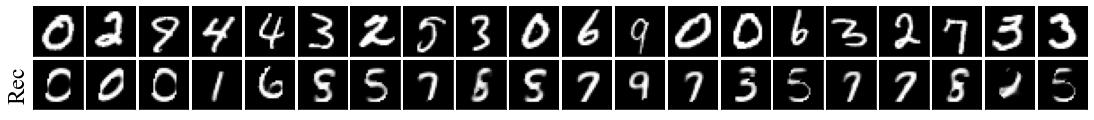

In [17]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

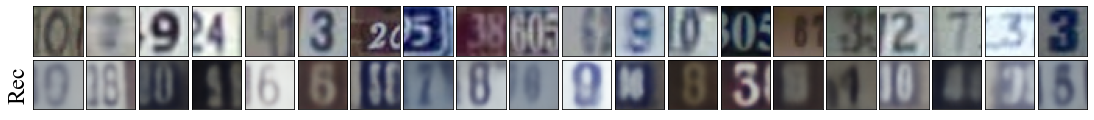

In [18]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

#### MNIST <- SVHN

In [19]:
correct = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            results = vae([None, data[1].to(device, dtype=torch.float32)], n_gibbs_iter=100)
        _, pred = clfs[0](results['x_rec'][0].cuda().view(-1, 1, 28, 28)).max(dim=1)
        correct.append((pred == data[2].to(device)).sum().item()/batch_size)
correct = np.array(correct)
correct.mean(), correct.std()

zpost mean: 0.2930137515068054 zppost mean: 0.3630126416683197
zprior mean: 0.31254342198371887 zpprior mean: 0.32684969902038574
zprior min: 2.980232238769531e-07 zpprior min: 5.438923835754395e-07
zpost min: 3.0100345611572266e-06 zppost min: 2.078711986541748e-06
zprior max: 3.5218772888183594 zpprior max: 3.4985949993133545
zpost max: 3.3534607887268066 zppost max: 4.506420612335205
zpost mean: 0.28945937752723694 zppost mean: 0.37146246433258057
zprior mean: 0.3159681558609009 zpprior mean: 0.32370424270629883
zprior min: 2.980232238769531e-07 zpprior min: 1.9492581486701965e-06
zpost min: 1.1920928955078125e-07 zppost min: 8.642673492431641e-07
zprior max: 3.1377804279327393 zpprior max: 3.7114925384521484
zpost max: 3.197701930999756 zppost max: 4.740422248840332
zpost mean: 0.28353151679039 zppost mean: 0.3817228078842163
zprior mean: 0.31198200583457947 zpprior mean: 0.32801854610443115
zprior min: 1.341104507446289e-07 zpprior min: 4.0978193283081055e-08
zpost min: 5.96046447

(0.10947516025641026, 0.023109469598208778)

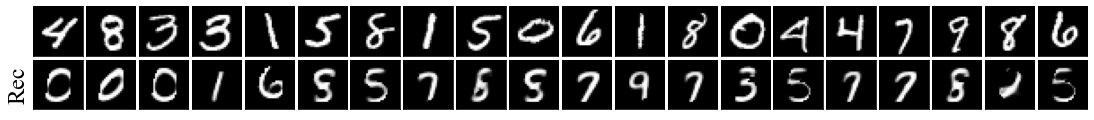

In [20]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

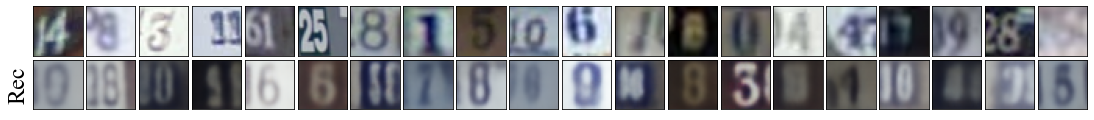

In [21]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

### Joint Generation

In [26]:
correct = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        with poisevae._debug.Capturing() as output:
            results = vae([None, None], n_gibbs_iter=100)
        _, pred1 = clfs[0](results['x_rec'][0].cuda().view(-1, 1, 28, 28)).max(dim=1)
        _, pred2 = clfs[1](results['x_rec'][1].cuda()).max(dim=1)
        correct.append((pred1 == pred2).sum().item()/batch_size)
correct = np.array(correct)
correct.mean(), correct.std()

zpost mean: 0.3141447603702545 zppost mean: 0.32641953229904175
zprior mean: 0.31254398822784424 zpprior mean: 0.3272334337234497
zprior min: 8.67992639541626e-07 zpprior min: 7.953494787216187e-07
zpost min: 8.861534297466278e-07 zppost min: 7.450580596923828e-07
zprior max: 3.1968300342559814 zpprior max: 3.7404961585998535
zpost max: 3.320437431335449 zppost max: 4.163379192352295
zpost mean: 0.3138589560985565 zppost mean: 0.3263706862926483
zprior mean: 0.3157699406147003 zpprior mean: 0.3241840600967407
zprior min: 8.493661880493164e-07 zpprior min: 2.8312206268310547e-07
zpost min: 2.6598572731018066e-06 zppost min: 1.385807991027832e-06
zprior max: 3.2642335891723633 zpprior max: 4.314855575561523
zpost max: 3.8615732192993164 zppost max: 3.193892478942871
zpost mean: 0.31145086884498596 zppost mean: 0.32833895087242126
zprior mean: 0.3114659786224365 zpprior mean: 0.3285596966743469
zprior min: 7.301568984985352e-07 zpprior min: 8.568167686462402e-07
zpost min: 1.7881393432617

(0.1201923076923077, 0.019848417125375252)

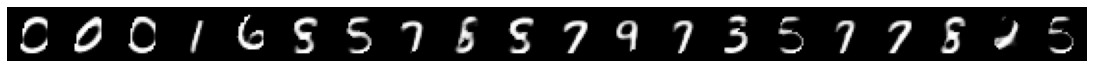

In [27]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 0.75))
for i, im in enumerate(x_rec[0]):
    if i >= ncols:
        break
    ax[i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    ax[i].set_axis_off()
# ax[0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

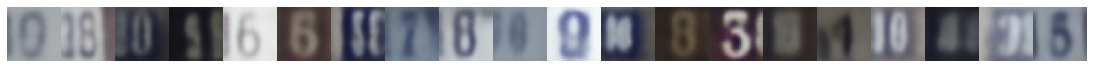

In [28]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 0.75))
for i, im in enumerate(x_rec[1]):
    if i >= ncols:
        break
    ax[i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    ax[i].set_axis_off()
# ax[0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)